# 강의 : https://www.edwith.org/boostcourse-ds-511/joinLectures/40944
# 강의자 repo : https://github.com/corazzon/boostcourse-ds-511

# 3.1 탐색한 데이터를 바탕으로 모델의 성능 개선하기

In [1]:
!git clone https://github.com/corazzon/boostcourse-ds-511.git

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import  accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns


diabetes_df = pd.read_csv('boostcourse-ds-511/data/diabetes.csv')

print(diabetes_df.shape)
pd.concat([ diabetes_df.iloc[:3], diabetes_df.iloc[-3:] ])

Cloning into 'boostcourse-ds-511'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 67 (delta 32), reused 49 (delta 16), pack-reused 0
Unpacking objects: 100% (67/67), done.
(768, 9)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


## 3.1.1 연속 수치 데이터를 범주형 변수로 변경하기
- 이산형 데이터인 pregnancies의 구간을 나눠 범주형으로 변경
- 데이터 변경으로 인한 모델 정확도 변화 확인

### 1) 학습-검증 데이터 분할

In [2]:
def split_train_val_xy(df, train_ratio=0.8, label_name='Outcome'):
  split_idx = int(df.shape[0] * train_ratio)

  train = df[:split_idx]
  X_train = train.drop(columns=label_name)
  y_train = train[label_name]

  validation = df[split_idx:]
  X_val = validation.drop(columns=label_name)
  y_val = validation[label_name]

  return X_train, X_val, y_train, y_val


X_train, X_val, y_train, y_val = split_train_val_xy(diabetes_df)

print('>>> shape of X_train, y_train :', X_train.shape, y_train.shape)
print('>>> shape of X_val, y_val     :', X_val.shape,   y_val.shape)
print()
display(X_train.head(3))

>>> shape of X_train, y_train : (614, 8) (614,)
>>> shape of X_val, y_val     : (154, 8) (154,)



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32


### 2) 데이터 전처리 - pregnancies → pregnancies_high
- 학습-검증 데이터 각각에 전처리 적용

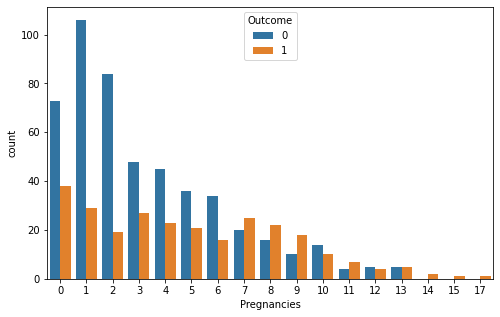


(614, 8) (154, 8)


In [3]:
# Reasong for Feature Engineering
plt.figure(figsize=(8, 5))
sns.countplot(x='Pregnancies', hue='Outcome', data=diabetes_df)
plt.show()
print()


# Feature Engineering
X_train['Pregnancies_high'] = X_train['Pregnancies'] > 6
X_train = X_train.drop(columns='Pregnancies')

X_val['Pregnancies_high'] = X_val['Pregnancies'] > 6
X_val = X_val.drop(columns='Pregnancies')

print(X_train.shape, X_val.shape)

### 3) 모델 학습&예측 및 결과 시각화

In [4]:
model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(accuracy_score(y_val, y_pred) * 100)

76.62337662337663


- 정확도가 기존 모델의 74.675에서 feature engineering 적용 이후 76.623으로 소폭 상승함

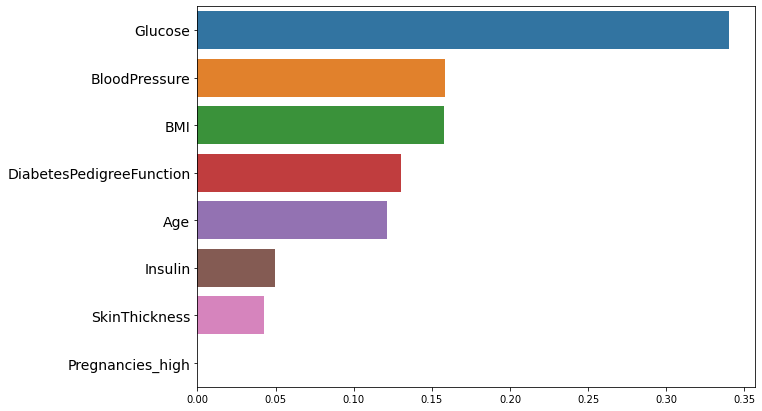

In [5]:
# Visualize feature importance
feature_names = X_train.columns
ftr_importance_df = pd.Series( model.feature_importances_, index=feature_names ).sort_values(ascending=False)

plt.figure(figsize=(10, 7))
sns.barplot(x = ftr_importance_df.values, y=ftr_importance_df.index)
plt.yticks(fontsize=14)
plt.show()
print()

- 새롭게 생성한 속성(Pregnancies_high)은 중요도가 거의 없음
- 성능 향상은 불필요 속성인 Prgnancies를 제거함으로써 획득된 것이라고 추정됨

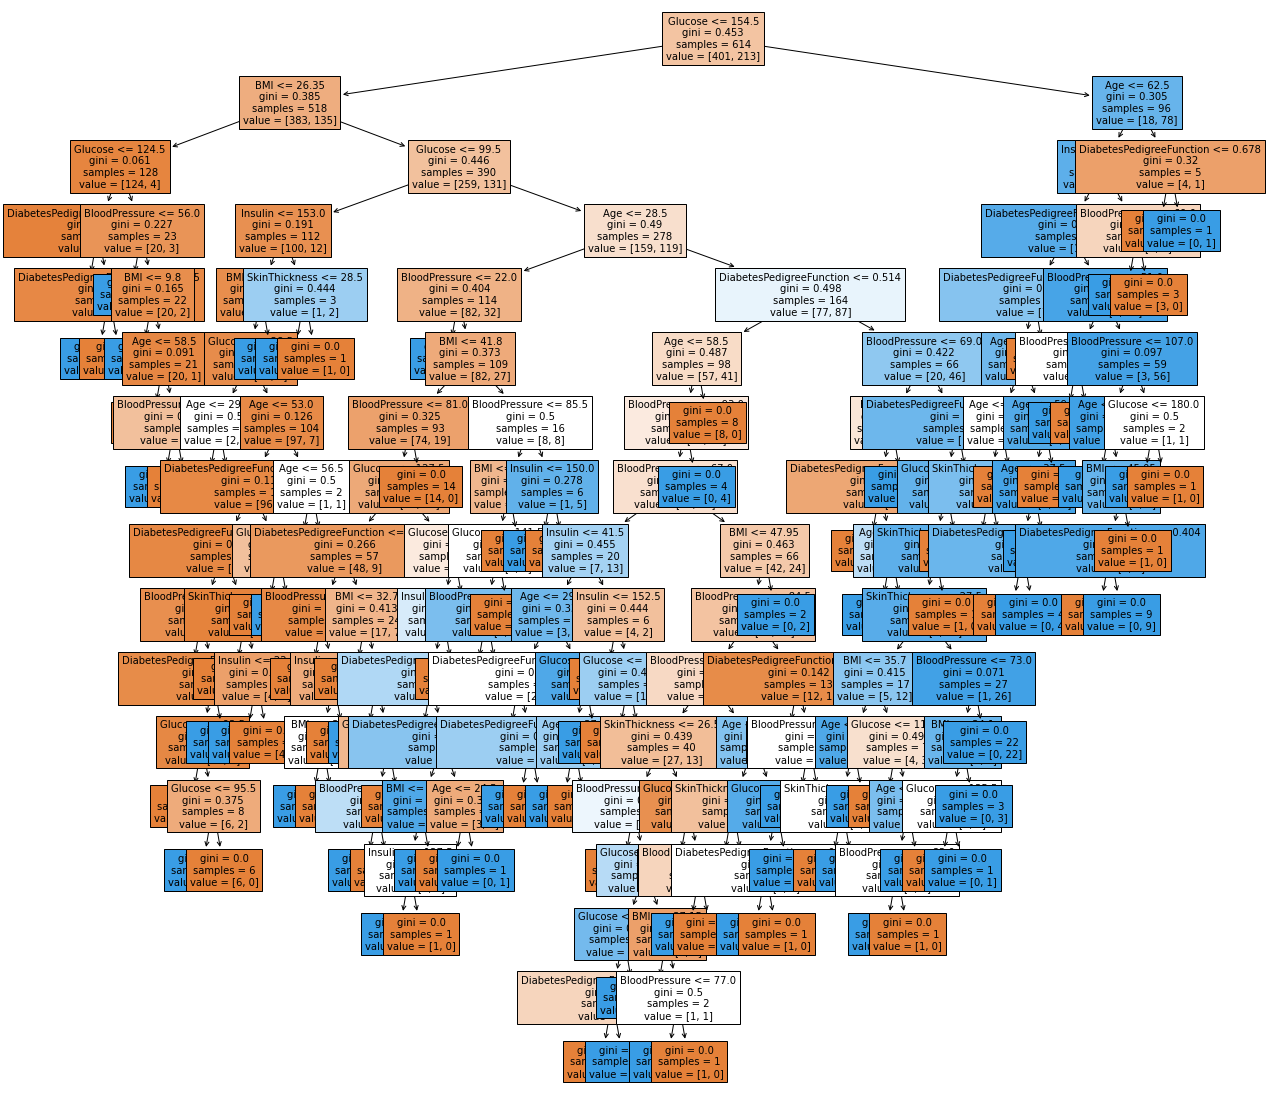

In [6]:
# Visualize whole tree
plt.figure(figsize=(20, 20))
plot = plot_tree(model, feature_names=feature_names, filled=True, fontsize=10)
plt.show()

## 3.1.2 범주형 변수를 수치형 변수로 변환하기 - 원핫인코딩
- 수치형 데이터인 Age의 구간을 세 개로 나누어 범주형으로 변경
- 나눠진 세 개의 범주에 원핫인코딩 적용
- 데이터 변경으로 인한 모델 정확도 변화 확인

### 1) 데이터 전처리 - Age → Age_low, Age_middle, Age_high
- 학습-검증 데이터 각각에 전처리 적용

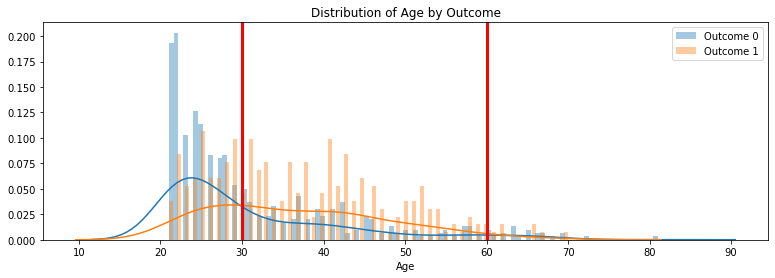

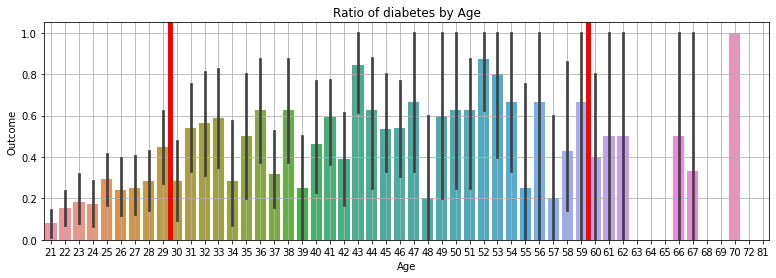


(614, 10) (154, 10)


,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Pregnancies_high,Age_high,Age_low,Age_middle
0,148,72,35,0,33.6,0.627,False,0,0,1
1,85,66,29,0,26.6,0.351,False,0,0,1
2,183,64,0,0,23.3,0.672,True,0,0,1


,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Pregnancies_high,Age_high,Age_low,Age_middle
614,138,74,26,144,36.1,0.557,True,0,0,1
615,106,72,0,0,25.8,0.207,False,0,1,0
616,117,96,0,0,28.7,0.157,False,0,0,1


In [7]:
# Reasong for Feature Engineering
plt.figure(figsize=(13, 4))
sns.distplot(diabetes_df.loc[diabetes_df.Outcome==0, 'Age'], bins=100, label='Outcome 0')
sns.distplot(diabetes_df.loc[diabetes_df.Outcome==1, 'Age'], bins=100, label='Outcome 1')
plt.axvline(30, color='red', linewidth=3)
plt.axvline(60, color='red', linewidth=3)
plt.title('Distribution of Age by Outcome')
plt.legend()
plt.show()

plt.figure(figsize=(13, 4))
sns.barplot('Age', 'Outcome', data=diabetes_df)
plt.axvline(8.5, color='red', linewidth=5)
plt.axvline(38.5, color='red', linewidth=5)
plt.title('Ratio of diabetes by Age')
plt.grid()
plt.show()
print()



# Feature Engineering
from sklearn.preprocessing import OneHotEncoder

## 수치형 데이터인 Age의 구간을 세 개로 나누어 범주형으로 변경
X_train['Age'] = X_train['Age'].map(lambda x : 'low' if x < 30 else 'high' if  x > 60 else 'middle')
X_val['Age'] = X_val['Age'].map(lambda x : 'low' if x < 30 else 'high' if  x > 60 else 'middle')

## 나눠진 세 개의 범주에 원핫인코딩 적용
enc_onehot = OneHotEncoder(dtype='int').fit(X_train['Age'].values.reshape(-1, 1))
def one_hot_new_df(df, enc=enc_onehot, col='Age'):
  onehot_df = pd.DataFrame(enc.transform(df[col].values.reshape(-1, 1)).toarray(),
                           columns=[f'{col}_{cat}' for cat in enc.categories_[0]],
                           index=df.index)
  new_df = pd.concat([df, onehot_df], axis=1).drop(columns=col)
  return new_df

X_train = one_hot_new_df(X_train)
X_val = one_hot_new_df(X_val)

print(X_train.shape, X_val.shape)
display(X_train.head(3))
display(X_val.head(3))

### 2) 모델 학습&예측 및 결과 시각화

In [8]:
model2 = DecisionTreeClassifier(random_state=0)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_val)
print(accuracy_score(y_val, y_pred2) * 100)

63.63636363636363


- 정확도가 74.675 → 76.623 → 63.636으로 대폭 하락함
- Feature Engineering이 반드시 성능 상승으로 이어지지는 않음

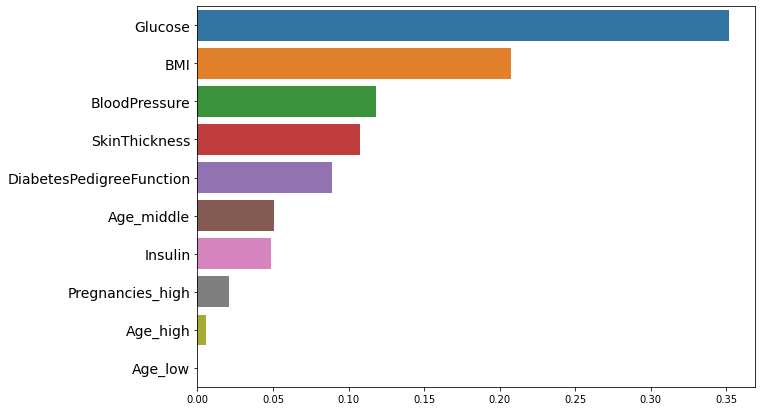

In [9]:
# Visualize feature importance
feature_names = X_train.columns
ftr_importance_df = pd.Series( model2.feature_importances_, index=feature_names ).sort_values(ascending=False)

plt.figure(figsize=(10, 7))
sns.barplot(x = ftr_importance_df.values, y=ftr_importance_df.index)
plt.yticks(fontsize=14)
plt.show()
print()

- 속성 중요도 상위 3개 속성은 변하지 않음
- Age_middle 속성이 포함됨

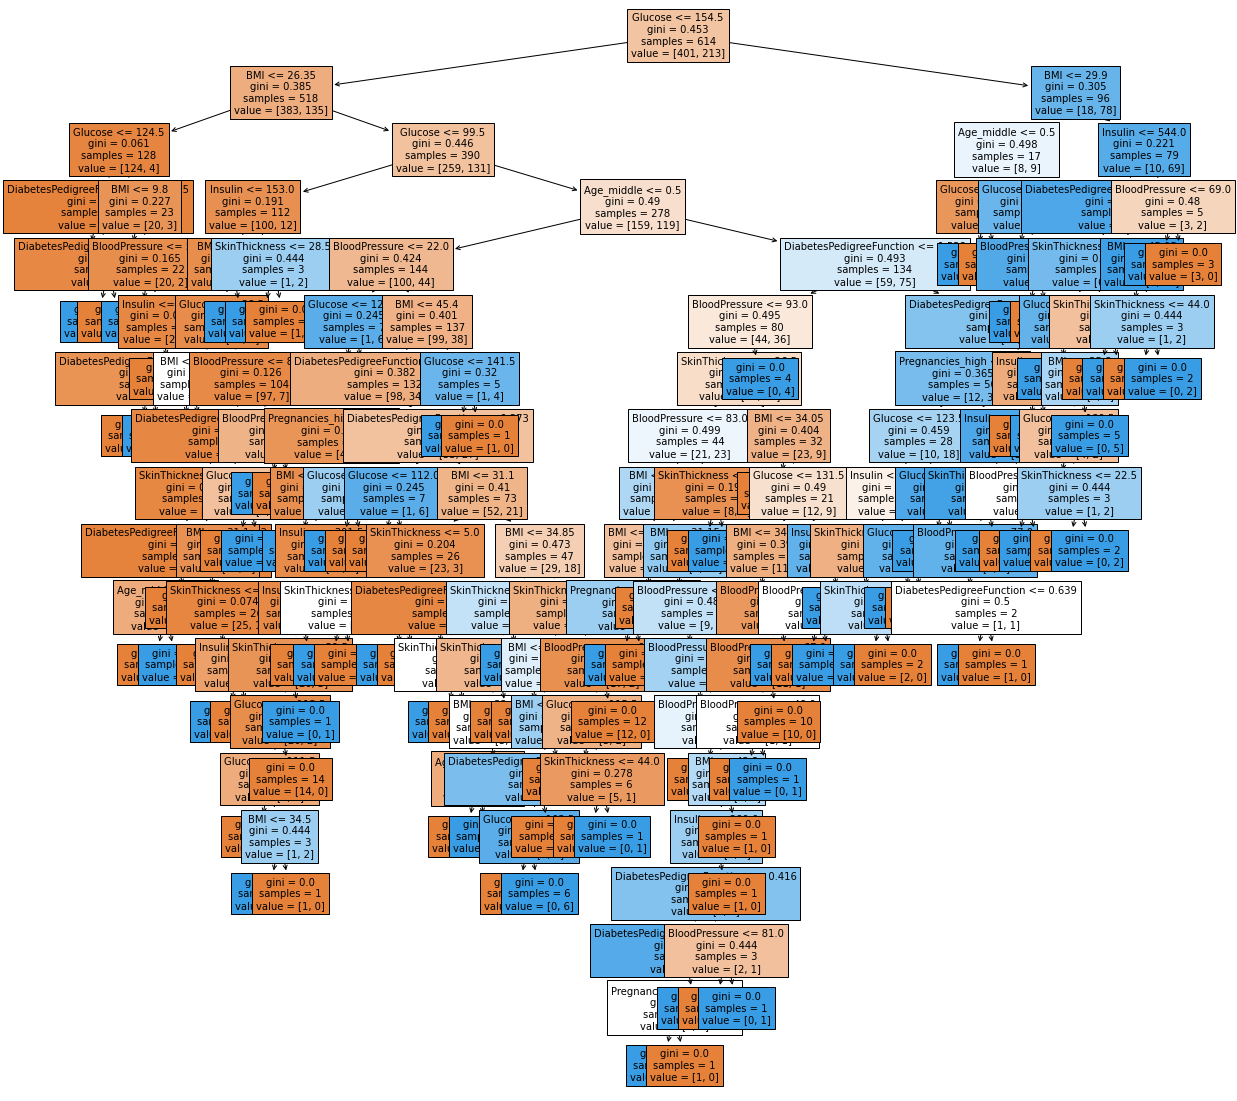

In [10]:
# Visualize whole tree
plt.figure(figsize=(20, 20))
plot = plot_tree(model2, feature_names=feature_names, filled=True, fontsize=10)
plt.show()